<table width="50%"><tr>
<td> <img src="../../img/dipy_logo.png" align="left" alt="Drawing" style="width: 155px;"/> </td>
<td> <img src="../../img/gsoc_logo.png" align="right" alt="Drawing" style="width: 220px;"/> </td>
</tr></table>

**Student**\
David Romero-Bascones\
**Mentors**\
Bramsh Qamar Chandio\
Shreyas Fadnavis\
Jong Sung Park

## **Probabilistic Atlas Bundle**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from dipy.io.image import load_nifti, save_nifti
from dipy.io.streamline import load_trk
from dipy.tracking.streamline import (unlist_streamlines, relist_streamlines,
                                      transform_streamlines, values_from_volume,
                                      set_number_of_points)

### Prepare data

In [2]:
in_dir = '/home/david/Dropbox (MGEP)/projects/GSoC-2021/data/PPMI_data/'
out_dir = '../results/'
subjects = pd.read_csv(in_dir + 'subjects.csv', delimiter='\t')
n_subject = subjects.shape[0]

tract = 'AF_L'
n_points = 20
save_atlas = False
verbose = True

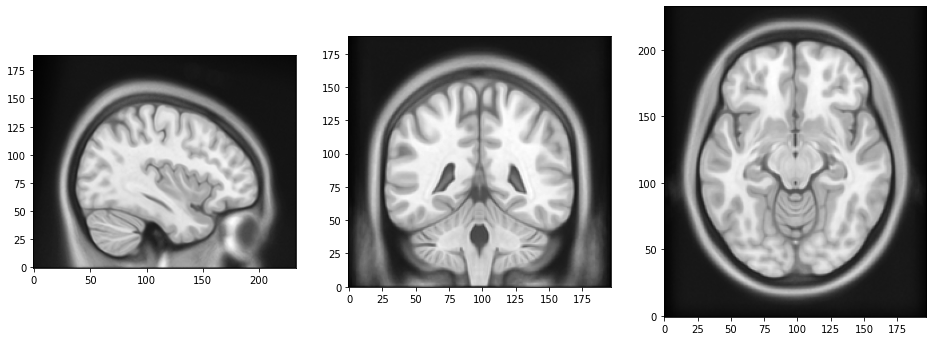

In [3]:
# Load MNI template """
image, affine = load_nifti('/home/david/Dropbox (MGEP)/projects/GSoC-2021/data/mni_template/mni_icbm152_t1_tal_nlin_asym_09a.nii')
dims = np.asarray(image.shape)
affine_inv = np.linalg.inv(affine)

fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[0].imshow(image[60,:,:].T, 'gray',origin='lower')
ax[1].imshow(image[:,90,:].T, 'gray',origin='lower')
ax[2].imshow(image[:,:,60].T, 'gray',origin='lower')
plt.show()

### Construct probabilistic atlas

In [4]:
# Loop through subjects """
dims_mask = np.concatenate((dims, [n_subject]))
mask = np.zeros(dims_mask)

for ind, sub in enumerate(subjects.participant):
    if verbose:
        clear_output(wait=True)
        print(f'{ind+1}/{n_subject}')
            
    # Load trk file
    file = f'{in_dir}/{sub}/rec_bundles/moved_{tract}__recognized.trk'
    bundle_obj = load_trk(file, reference='same', bbox_valid_check=False)

    # Get streamlines and preprocess them
    points, offset = unlist_streamlines(bundle_obj.streamlines)
    streamlines = relist_streamlines(points, offset)
    streamlines = set_number_of_points(streamlines, n_points)

    # Transform coordinates to voxel space
    streamlines_vox = transform_streamlines(streamlines, affine_inv)

    # Round voxel coordinates and cast them to int
    points, offsets = unlist_streamlines(streamlines_vox)
    streamlines_ind = np.round(points).astype('int')

    # Create coverage mask
    n_point = streamlines_ind.shape[0]
    for i_stream in range(n_point):
        i = streamlines_ind[i_stream, 0]
        j = streamlines_ind[i_stream, 1]
        k = streamlines_ind[i_stream, 2]

        mask[i, j, k, ind] = 1

# Combine subject coverage masks
prob_atlas = mask.sum(axis=3)/n_subject

# Save the atlas
if save_atlas:
    file = f'{out_dir}/prob_atlas_{tract}.nii'
    save_nifti(file, prob_atlas, affine)

64/64


### Visualize the results

In [5]:
# Set 0s to nan for visualization
ind = np.argwhere(prob_atlas==0)
prob_atlas_viz = prob_atlas.copy()
for i in ind:
    prob_atlas_viz[i[0],i[1],i[2]] = np.nan

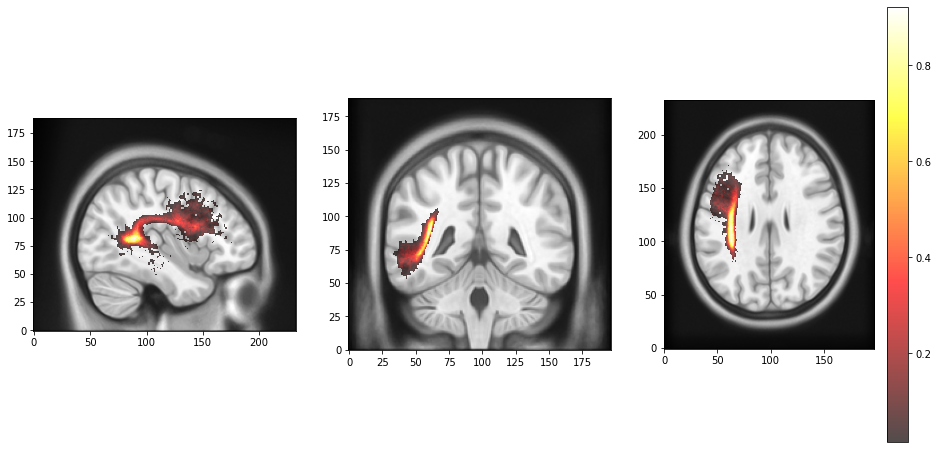

In [6]:
i_slice = [58, 90, 100]
alpha = 0.7

fig, ax = plt.subplots(1,3, figsize=(16,8))

ax[0].imshow(image[i_slice[0],:,:].T,'gray',origin='lower')
ax[0].imshow(prob_atlas_viz[i_slice[0],:,:].T,'hot',alpha=alpha, origin='lower')

ax[1].imshow(image[:, i_slice[1],:].T,'gray',origin='lower')
ax[1].imshow(prob_atlas_viz[:,i_slice[1],:].T,'hot',alpha=alpha,origin='lower')

ax[2].imshow(image[:,:,i_slice[2]].T,'gray',origin='lower')
im = ax[2].imshow(prob_atlas_viz[:,:,i_slice[2]].T,'hot',alpha=alpha,origin='lower')
fig.colorbar(im, ax=ax[2])
plt.show()

#### Interactive visualization

In [7]:
from ipywidgets import interact

def plot_data(alpha, i, j, k):
    fig, ax = plt.subplots(1, 3, figsize=(16, 7))  
    
    ax[0].imshow(image[i,:,:].T,'gray',origin='lower')
    ax[0].imshow(prob_atlas_viz[i,:,:].T,'hot',alpha=alpha, origin='lower')

    ax[1].imshow(image[:, j,:].T,'gray',origin='lower')
    ax[1].imshow(prob_atlas_viz[:,j,:].T,'hot',alpha=alpha,origin='lower')

    ax[2].imshow(image[:,:,k].T,'gray',origin='lower')
    ax[2].imshow(prob_atlas_viz[:,:,k].T,'hot',alpha=alpha,origin='lower')
    
    plt.show()
    
y = interact(plot_data, alpha=(0,1,0.01), i=(0,image.shape[0]-1,1),j=(0,image.shape[1]-1,1),k=(0,image.shape[2]-1,1)) 
display(y)

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.01), IntSlider(value=98, des…

<function __main__.plot_data(alpha, i, j, k)>